In [1]:
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torchvision import datasets, transforms

Let us define a QNN with the following ansatz:
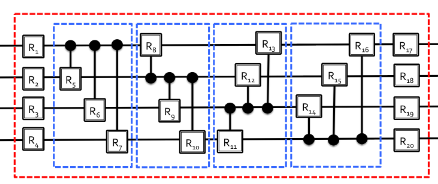

I implement this system such that we compress a 4 qubit state to a 2 qubit state. In terms of the language of the paper, n + k = 4 and n = 2. Thus, n = 2, k = 2. We have an additional qubit (with index 0 here) to do the SWAP test.

Upon SWAP test, this additional is measured in state 0 with probability $$ p_0 = \frac{1}{2} + \frac{F}{2} $$ where $F$ is the fidelity that we are concerned with (equivalent to fidelity between input and recovered state after all the tracing out and other algebra as mentioned in the paper).

Note that I have slightly modified the loss function from what is suggested in the paper. Though still the loss function denotes how bad the system is performing.

In [2]:
class QAE_nn(nn.Module):
    def __init__(self, dev, wires, trash_subsystem_size):
        super(QAE_nn, self).__init__()
        
        self.wires = wires
        self.trash_subsystem_size = trash_subsystem_size
        self.U_size = wires - trash_subsystem_size - 1
        self.dev = dev
        
        @qml.qnode(dev)
        def circuit(params, inputs = False):
            qml.templates.embeddings.AngleEmbedding(inputs[1 + self.trash_subsystem_size:], wires = range(1 + self.trash_subsystem_size, wires))
            index_offset = 0
            for i in range(1 + self.trash_subsystem_size, wires):
                qml.Rot(params[index_offset], params[index_offset + 1], params[index_offset + 2], wires = i)
                index_offset += 3
            
            for i in range(1 + self.trash_subsystem_size, wires):
                for j in range(1 + self.trash_subsystem_size, wires):
                    if i != j:
                        qml.CRot(params[index_offset], params[index_offset + 1], params[index_offset + 2], wires = [i, j])
                        index_offset += 3
            
            for i in range(1 + self.trash_subsystem_size, wires):
                qml.Rot(params[index_offset], params[index_offset + 1], params[index_offset + 2], wires = i)
                index_offset += 3
            
            # Performing SWAP TEST
            qml.Hadamard(wires = 0)
            for i in range(self.trash_subsystem_size):
                qml.CSWAP(wires = [i, i + 1, 2*self.trash_subsystem_size - i])
            qml.Hadamard(wires = 0)
            
            #Only care about the probability of measuring 0 after the SWAP test.            
            return qml.probs(wires = 0)
        param_shape = {"params" : 3*self.U_size*(1 + self.U_size)}        
        self.qlayer = qml.qnn.TorchLayer(circuit, param_shape)
    
    def forward(self, x, training_mode = True):
        self.training_mode = training_mode
        x = self.qlayer(x)
        return x

def loss_func(output):
    prob = torch.squeeze(output)[0]
    return 1/prob

We donload standard dataset and mould it to our desired size (2x2) to train our QNN.

In [3]:
training_data = datasets.MNIST(root = './standard_dataset', train = True, download = True, transform = transforms.Compose([transforms.Resize((2,2)), transforms.ToTensor()]))

In [4]:
epochs = 2500
lr = 0.001

U_size = 4
latent_qubits = 2
trash_subsystem_size = U_size - latent_qubits
wires = 1 + trash_subsystem_size + U_size

dev = qml.device("default.qubit", wires = wires)
encoder = QAE_nn(dev = dev, wires = wires, trash_subsystem_size = trash_subsystem_size)
opt = torch.optim.Adam(encoder.parameters(), lr = lr)

In [5]:
for epoch in range(epochs):
    opt.zero_grad()
    input_data = torch.reshape(training_data[epoch][0], (1, U_size))
    input_item = torch.cat((torch.zeros([1, 1 + trash_subsystem_size]), input_data), 1)
    output = encoder.forward(input_item, True)
    loss = loss_func(output)
    loss.backward()
    opt.step()

### Testing
Having trained the system, now is our time to test it. Let us take some random binary vector of length 4. Now, note that based on our definition of the QNN earlier, the variable `output` basically represents a tensor with the probability of measuring state 0 and state 1 when we measure the SWAP qubit.

Note that, when the fidelity is 1, the probability of measuring 0 is 1. And in turn, the `loss` is also 1. As the fidelity goes lowe, the probability also goes lower, and as a result the loss goes up. So the minimum loss achievable is 1.

In [7]:
random_test_input = torch.tensor(np.array([[np.random.choice(2) for i in range(4)]]))
full_test_input = torch.cat((torch.zeros([1, 1 + trash_subsystem_size]), random_test_input), 1)
print(random_test_input)
output = encoder.forward(full_test_input, False)
print(output)

tensor([[0, 0, 1, 0]])
tensor([[0.9358, 0.0642]], grad_fn=<StackBackward>)


In [8]:
print(loss)

tensor(1.0010, grad_fn=<MulBackward0>)
